# Atividade 1 
Neste trabalho, você terá que entregar um notebook (preferencialmente, um link para um Colab) que implementa um auto-encoder. Para isso:

- Assista aos vídeos de Perceptron e MLP feitos só com numpy. Sua implementação deve seguir o que está lá, porém...
- Sua implementação deve permitir o usuário definir a arquitetura, ou seja, quantas camadas e quantos neurônios em cada uma delas eu vou querer usar. Explique no notebook como é o formato para eu definir isso.
- O notebook deve ter seções e textos explicativos. Ou seja, deve have uma documentação interna.
- Eu testarei com dados sintéticos, como os feitos para as aulas de Perceptron e MLP na prática. Porém, serão melhores (mais atributos, mais intersecção entre os "blobs", etc).


Grupo:

| Nome          | nUSP     |
|---------------|----------|
| Rafael Zimmer | 12542612 |
| Murilo Soave  |          |

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Gerando o conjunto de dados:

Vamos criar um conjunto de dados sintético para testar o multi-layer perceptron.
Para a atividade, vamos definir uma estrutura que permita multiplas classes e multiplas colunas.

--------------------------------------------
### Função generate_class(mu, sigma, n)
Essa função gera dados para uma única classe com base nos parâmetros fornecidos:

* mu: a média da distribuição normal que define a classe.
* sigma: o desvio padrão da distribuição normal que define a classe.
* n: o número de observações a serem geradas.

A função numpy.random.normal() é usada para gerar os dados de acordo de uma forma estável com a distribuição normal, retornando um array com n observações.

--------------------------------------------

### Função generate_data(classes)
Essa função gera dados para várias classes, onde cada classe é definida por um conjunto de parâmetros.

* classes: um dicionário onde as chaves representam os rótulos das classes e os valores são tuplas contendo o número de observações (n) e uma lista de pares (mu, sigma) representando os parâmetros da distribuição normal para cada coluna.
A função itera sobre as classes fornecidas, gerando dados para cada uma delas usando a função generate_class(). Em seguida, concatena os dados gerados para todas as classes e adiciona codificação one-hot para os rótulos das classes. Por fim, embaralha os dados e os retorna.

Em suma, esses dois métodos servem para facilitar gerar distribuições de dados separáveis e não separáveis para testar o MLP. 

--------------------------------------------

In [143]:
def generate_class(mu, sigma, n):
    return np.random.normal(mu, sigma, n)


def generate_data(classes):
    data = []
    for label, params in classes.items():
        n, columns = params
        
        observations_T = []
        
        for mu, sigma in columns:
            observations_T.append(generate_class(mu, sigma, n))
        
        observations = np.array(observations_T).T
        # one hot encoding
        y_true = np.zeros((n, len(classes)))
        y_true[:, label] = 1
        
        data.append(np.concatenate([observations, y_true], axis=1))
    
    sorted_data = np.concatenate(data, axis=0)  
    
    return np.random.permutation(sorted_data)

In [140]:
classes = {
    0: (1000, [(10, 1), (1, 1)]),
    1: (1000, [(5, 1), (0, 1)]),
}

In [212]:
data = generate_data(classes)
print(data[:5])
print(data.shape)

[[ 4.77897415  1.14693868  0.          1.        ]
 [ 8.82031236  1.00759885  1.          0.        ]
 [ 9.81014921  0.82554253  1.          0.        ]
 [10.6031966   1.0418482   1.          0.        ]
 [10.07324342  1.3876382   1.          0.        ]
 [ 4.33073839 -0.56754391  0.          1.        ]
 [ 9.80306419  1.71585939  1.          0.        ]
 [ 9.14200119  1.68981127  1.          0.        ]
 [ 9.38933619  1.04312668  1.          0.        ]
 [10.6701688   3.44614435  1.          0.        ]]
(2000, 4)


## Visualizando o conjunto de dados

Para facilitar a visualização, vamos gerar dados com apenas 2 dimensões. Cada classe é representada por uma cor diferente.

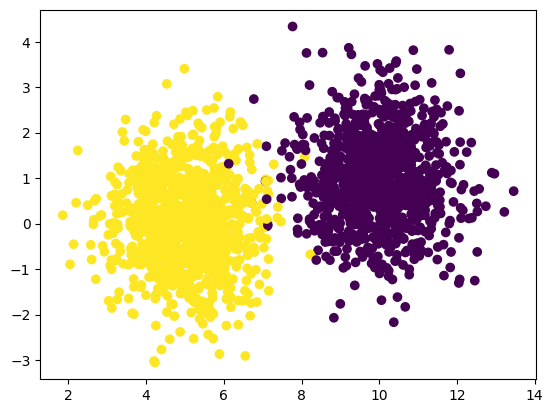

In [146]:
labels = np.argmax(data[:, 2:], axis=1)
plt.scatter(data[:, 0], data[:, 1], c=labels)

## Definindo uma Loss function

Essas classes são utilizadas para definir e calcular os erros dos modelos, especificamente a Cross Entropy, comum para problemas de classificação multiclasse.

------------------------------------
### Classe CrossEntropy
Essa classe implementa a função de entropia cruzada, que parte da definição de entropia de sistemas dinâmicos, na física.

softmax(self, x): Método que calcula a função softmax de um vetor x. Isso é usado para converter as saidas de um modelo em probabilidades.

__call__(self, y_true, y_pred): Calcula a entropia cruzada entre as previsões y_pred e os rótulos verdadeiros y_true. Também guarda o valor do loss e calcula o gradiente.

gradient(self, y_true, y_pred): Utilizado para retornar o gradiente calculado.

Em suma, a cross entropy usa a função softmax internamente para converter as saidas numéricas no domínio dos reais em probabilidades e calcula a perda e o gradiente com base nessas probabilidades e nos _labels_ verdadeiros.

------------------------------------

In [204]:
from abc import ABC, abstractmethod
    
    
class Loss(ABC):
    @abstractmethod
    def __call__(self, y_true, y_pred):
        pass
    
    @abstractmethod
    def gradient(self, y_true, y_pred):
        pass
    
    
class CrossEntropy(Loss):
    def softmax(self, x):
        exps = np.exp(x - x.max())
        # non-batched implementation
        return exps / exps.sum()
    
    def error(self, y_true, y_pred):
        return -np.mean(y_true * np.log(y_pred))
    
    def gradient(self, y_true, y_pred):
        return y_pred - y_true
    
    def __call__(self, y_true, y_pred):
        y_pred = self.softmax(y_pred)
        return self.error(y_true, y_pred), self.gradient(y_true, y_pred)
    
    
class Activation:
    pass


class Tanh(Activation):
    def __call__(self, x):
        return np.tanh(x)
    
    def gradient(self, x):
        return 1 - np.tanh(x) ** 2
    

class ReLU(Activation):
    def __call__(self, x):
        return np.maximum(0, x)
    
    def gradient(self, x):
        return (x > 0).astype(int)

## Implementando o MLP em si

Classe MLP (_Multi-Layer Perceptron_):

* __init__(self, layers): O construtor inicializa os parâmetros da rede neural com base nas camadas fornecidas. _layers é uma lista que especifica o número de neurônios em cada camada.
* forward(self, x): Realiza a operação de feedforward na rede neural, aplicando a função de ativação camada à camada. É em essência um loop de produtos matriciais com pesos e passe das ativações (tornando o modelo não linear).
* backward(self, grad, lr=0.01): Faz o _backpropagation_ do gradiente na rede neural, atualizando os pesos e os viéses com base no gradiente descendente estocástico (SGD). (O valor grad é o gradiente da função de _loss_ em relação à saída da rede neural).
* pred(self, x=None, value=None): Retorna o y_hat da rede neural com base nas entradas fornecidas x ou em valores value.

Essa classe é uma implementação simples do que será utilizado para um exemplo de Autoencoder no final, com hidden layers não simétricas.

In [509]:
class Module(ABC):
    def __init__(self):
        self.error = None
        pass
    
    def forward(self, x):
        pass
    
    def __call__(self, x):
        return self.forward(x)
    
    def backward(self, x, y, lr=None):
        pass

class MLP(Module):
    def __init__(self, layers, error, activations=None):
        super().__init__()
        self.layers = layers
        self.activations = activations
        self.error = error
        self.weights = []
        self.biases = []
        self.zs = []
        
        for i in range(1, len(layers)):
            self.weights.append(np.random.randn(layers[i-1], layers[i]))
            self.biases.append(np.random.randn(layers[i]))
            self.zs.append(None)
        self.zs.append(None)
        
    def __call__(self, x):
        return self.forward(x)
    
    def weights(self):
        return self.weights
    
    def pred(self, x=None, value=None):
        def _to_class(y):
            return np.argmax(y, axis=1)
        if value is not None:
            return _to_class(value)
        elif x is not None:
            return _to_class(self.forward(x))
        else:
            raise ValueError('x or value must be provided')
    
    def forward(self, x):
        self.zs[0] = x
        for i in range(len(self.layers) - 1):
            x = np.dot(x, self.weights[i]) + self.biases[i]
            self.zs[i+1] = x
            x = self.activations[i](x)
        return x

    def backward(self, x, y, lr=0.01):
        y_pred = self.forward(x)
        grad = self.error.gradient(y, y_pred)
        
        for i in range(len(self.layers) - 1, 0, -1):
            grad = grad * self.activations[i-1].gradient(self.zs[i])
            self.weights[i-1] -= np.dot(self.zs[i-1].T, grad)
            self.biases[i-1] -= np.sum(grad, axis=0)
            
            grad = np.dot(grad, self.weights[i-1].T)

In [510]:
from tqdm.notebook import tqdm

In [511]:
def train(dataset, model: Module, criterion: Loss, lr=1e-4, epochs=1000):
    losses = [+np.inf]
    plt.ion()  # Turn on interactive mode
    fig, ax = plt.subplots()
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss')
    
    for epoch in tqdm(range(epochs)):
        loss = +np.inf
        for x, y in dataset:
            y_hat = model.forward(x)
            loss, _ = criterion(y, y_hat)
            
            model.backward(
                x, y,
                lr=lr
            )
        if epoch % 50 == 0:
            losses.append(loss)
            print(f'Epoch {epoch} - Loss: {loss}')
            
            ax.plot(losses[1:], '-o', color='b')
            fig.canvas.draw()
            fig.canvas.flush_events()
            
        if np.abs(loss) < 1e-3 or np.isnan(loss) or np.abs(losses[-1] - losses[-2]) < 1e-6:
            break
            
    return losses

In [512]:
classes = {
    0: (1000, [(10, 1), (1, 1)]),
    1: (1000, [(5, 1), (0, 1)]),
    # 2: (1000, [(-1, 1), (-1, 1)]),
    # 3: (1000, [(-5, 1), (-2, 1)]),
}

data = generate_data(classes)
dataset = [(x[:2], x[2:]) for x in data]

criterion = CrossEntropy()

mlp = MLP([
    2,  # input layer
    10,  # hidden layer
    2,  # output layer
], activations=[Tanh(), Tanh()], error=criterion)
lr = 1e-2


print([mlp.forward(x) for x, _ in dataset[:5]])

[array([-0.99814829, -0.96094933]), array([-0.96877824,  0.63507917]), array([-0.9882778 ,  0.71340153]), array([-0.98837995,  0.7153817 ]), array([ 0.81217855, -0.36014945])]


In [518]:
x, y = dataset[0]
y_pred = mlp.forward(x)
grad = mlp.error.gradient(y, y_pred)

i = len(mlp.layers) - 1
grad = grad * mlp.activations[i-1].gradient(mlp.zs[i])

print(mlp.zs[i - 1].T.shape)

np.dot(mlp.zs[i].T, grad).shape

(10,)


()

  0%|          | 0/500 [00:00<?, ?it/s]

ValueError: shapes (10,) and (2,) not aligned: 10 (dim 0) != 2 (dim 0)

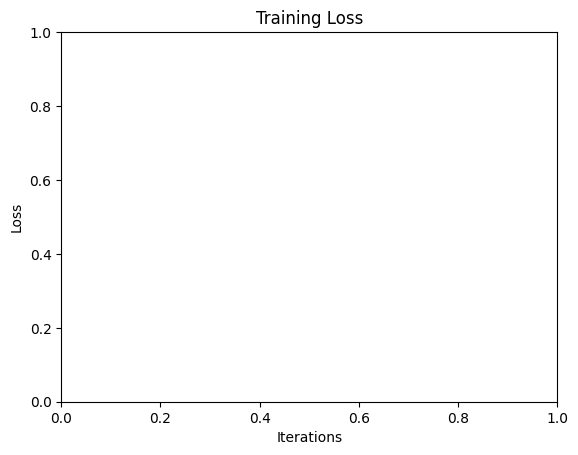

In [514]:
losses = train(dataset, mlp, criterion, lr=lr, epochs=500)

In [ ]:
class Autoencoder(Module):
    def __init__(self, encoder_layers, decoder_layers):
        super().__init__()
        self.encoder = MLP(encoder_layers)
        self.decoder = MLP(decoder_layers)
        
    def weights(self):
        return self.encoder.weights, self.decoder.weights
        
    def forward(self, x):
        return self.decoder(self.encoder(x))

    def backward(self, grad, lr=0.01):
        grad = grad * lr
        grad = self.decoder.backward(grad, lr)
        grad = self.encoder.backward(grad, lr)
        
        return grad
    
    def __call__(self, x):
        return self.forward(x)
    
    def encode(self, x):
        return self.encoder(x)

In [484]:
# 5 columns classes
classes = {
    0: (1000, [(10, 1), (1, 1), (0, 1), (0, 1), (0, 1)]),
    1: (1000, [(5, 1), (0, 1), (0, 1), (0, 1), (0, 1)]),
    2: (1000, [(-1, 1), (-1, 1), (0, 1), (0, 1), (0, 1)]),
    3: (1000, [(-5, 1), (-2, 1), (0, 1), (0, 1), (0, 1)]),
}
data = generate_data(classes)

dataset = [(x[:5], x[5:]) for x in data]

print(data.shape)

(4000, 9)


  0%|          | 0/500 [00:00<?, ?it/s]

TypeError: 'NoneType' object is not subscriptable

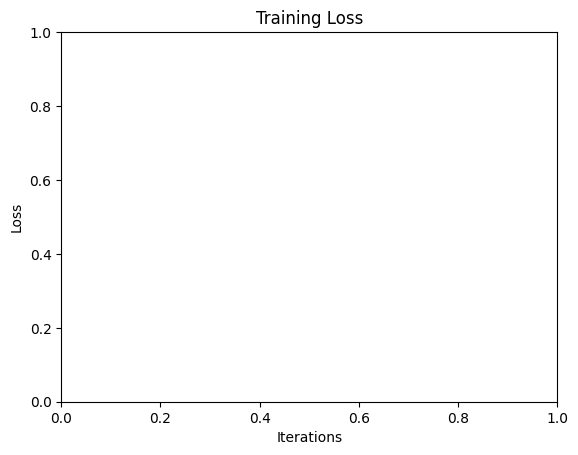

In [485]:
autoencoder = Autoencoder(
    encoder_layers=[5, 10, 4, 2],
    decoder_layers=[2, 4, 10, 4],
)

lr = 1e-4

train(dataset, autoencoder, criterion, lr=lr, epochs=500)

In [ ]:
plt.scatter(data[:, 0], data[:, 1], c=autoencoder.pred(data[:, :5]))